## Temperature Forecasting

In [1]:
import pandas as pd
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Preparation


#### Load Data

In [2]:
!dir

 Volume in drive D is CODE
 Volume Serial Number is 80B7-ABD7

 Directory of D:\Machine Learning\deep-learning-with-pytorch\time series

17-05-2021  13:01    <DIR>          .
17-05-2021  13:01    <DIR>          ..
16-05-2021  11:06    <DIR>          .ipynb_checkpoints
16-05-2021  22:49           143,845 sequence_data.jpg
17-05-2021  13:01            15,360 temperature_forecasting_lstm.ipynb
               2 File(s)        159,205 bytes
               3 Dir(s)  210,758,504,448 bytes free


In [3]:
data_dir = "D:\Machine Learning\deep-learning-with-pytorch\data\jena_climate_2009_2016"
dataset_path = os.path.join(data_dir, "jena_climate_2009_2016.csv")

In [4]:
df = pd.read_csv(dataset_path)

In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

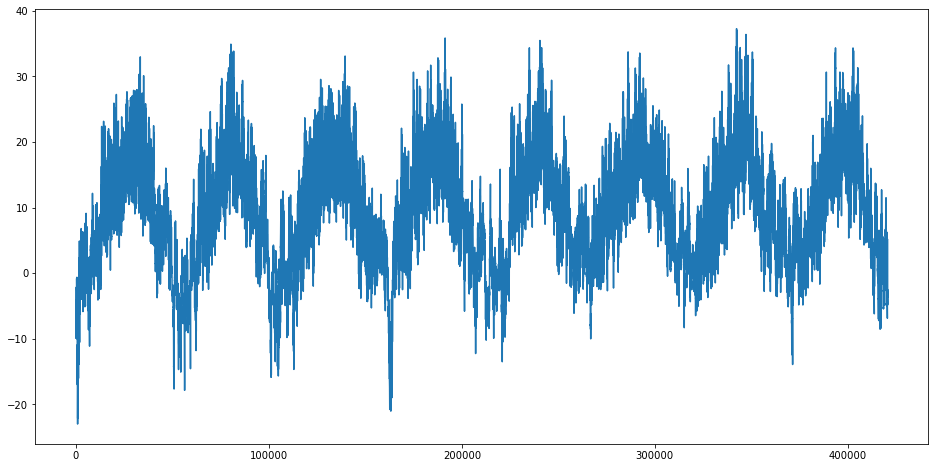

In [7]:
plt.figure(figsize=(16, 8))
plt.plot(df["T (degC)"])

We can observe periodicity over a large period of time

Now let's check if the data is periodic for a small duration - say 10 days

Data is recorded for every 10 min, that means there are 24 * 60 / 10 = 144  recordings per day.

Let's see how the temperature varies for 10 days i.e plot for 144 * 10 = 1440 recordings

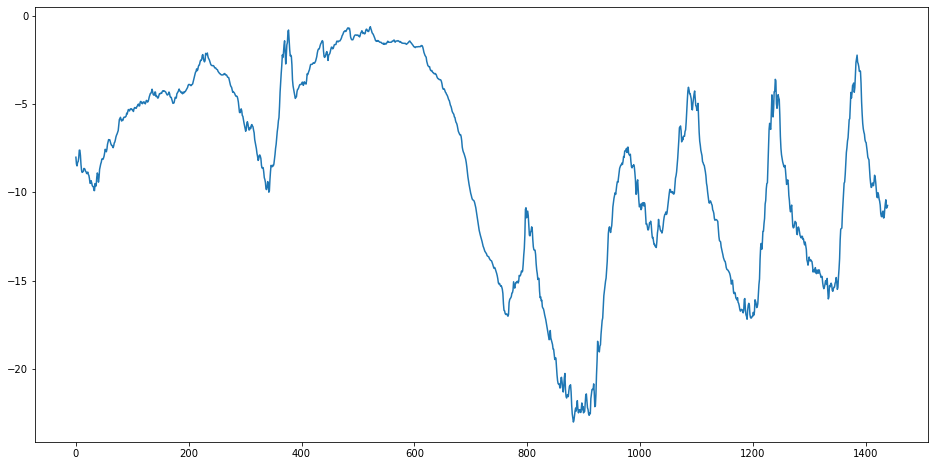

In [8]:
plt.figure(figsize=(16, 8))
plt.plot(df["T (degC)"][:1440])

We can see that the temperature is chaotic in the beginning but periodic in the end

#### Data Preprocessing

In [9]:
def convert_degree_to_kelvin(degree):
    return degree + 273

In [10]:
df["T (degC)"] = df["T (degC)"].apply(lambda T_c: convert_degree_to_kelvin(T_c))
df["Tdew (degC)"] = df["Tdew (degC)"].apply(lambda T_c: convert_degree_to_kelvin(T_c))

In [11]:
# note that since this is a time series problem, our input data will consist of everything,
# including the current temperature which we will use to predict future temperature

data = df[df.columns[1:]]

In [12]:
data.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

##### Normalize Data

In [13]:
mean = data.mean(axis=0)
std = data.std(axis=0)

In [14]:
data_normalized = (data - mean) / std

In [15]:
# check if the data is correctly normalized
assert np.sum(data["T (degC)"]  != data_normalized["T (degC)"] * std["T (degC)"] + mean["T (degC)"]) == 0

In [16]:
data_normalized = data_normalized.values

In [17]:
total_samples = len(data)

In [18]:
total_samples

420551

#### Problem Formulation

- Our input would be past observations of 5 days i.e 144 * 5 = 720 records
- However, we subsample data once every hour i.e every 6 records 
- our target would be to predict temperature 24 hrs in the future i.e 144 records

In [19]:
# defining parameters as per the discussion above
lookback = 720 # (i) sequence length
steps = 6 # (ii) subsample rate
delay = 144 # (iii) target

#### Create Generator

In [20]:
def create_generator(data, min_index, max_index, lookback, delay, step=6, batch_size=128):
    i = min_index + lookback 
    while 1:
        rows = np.arange(i, min(i + batch_size, max_index))
        i += len(rows) 
        samples = np.zeros((len(rows), lookback // step, data.shape[-1])) # n_sequences, sequence_length, n_features per sequence
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1] * std["T (degC)"] + mean["T (degC)"] # we don't normalize the target generally
            
        yield samples, targets

##### Refer to the picture below to understand the reasoning of the data generator

In [21]:
from PIL import Image

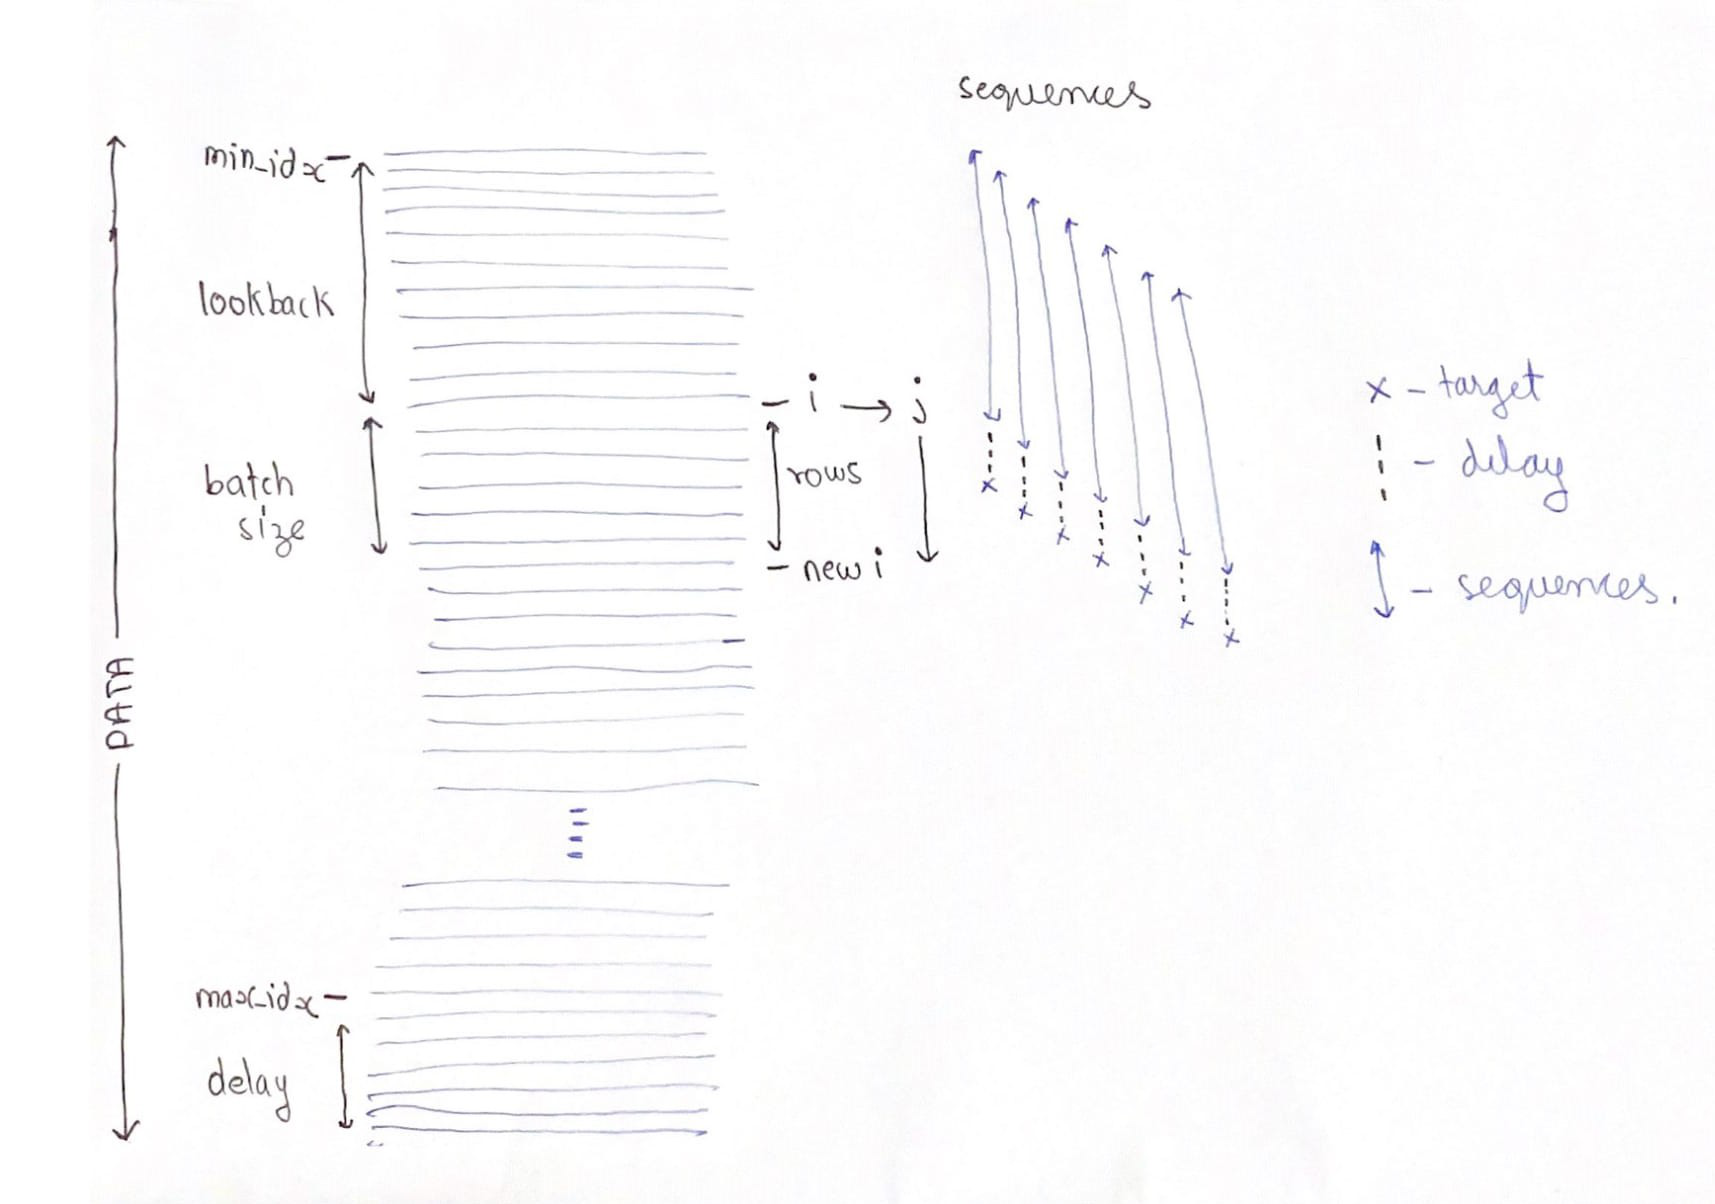

In [22]:
Image.open("sequence_data.jpg")

In [23]:
min_index = 0
max_index = total_samples - delay - 1

In [24]:
gen = create_generator(data_normalized, min_index, max_index, lookback, delay)

In [25]:
sequences_g, labels_g = next(gen)

In [26]:
sequences_g.shape, labels_g.shape

((128, 120, 14), (128,))

#### Create Pytorch Dataset

##### Let's try to create the same in pytorch using the Dataset class

In [27]:
from torch.utils.data import Dataset, DataLoader

In [28]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback, delay, steps=6):
        self.data = data
        self.lookback = lookback
        self.delay = delay
        self.steps = steps
        self.n_sequences = self.__len__()
        
    def __len__(self):
        return len(self.data) - self.lookback - self.delay
    
    def __getitem__(self, idx):
        assert idx < self.n_sequences
        sequence = torch.zeros((self.lookback // self.steps, self.data.shape[-1]))
        
        indices = torch.arange(idx, idx + self.lookback, self.steps)
        sequence[:, :] = self.data[indices]
        
        target = self.data[idx + self.lookback + self.delay][1] * std["T (degC)"] + mean["T (degC)"]
        
        return sequence, target

In [29]:
dataset = TimeSeriesDataset(torch.from_numpy(data_normalized), lookback, delay)

In [30]:
dataloader = DataLoader(dataset, batch_size=128,shuffle=False)

In [31]:
for sequences_dl, labels_dl in dataloader: 
    sequences_dl = np.round(sequences_dl.numpy(), 3)
    labels_dl = np.round(labels_dl.numpy(), 3)
    break

In [32]:
sequences_g = np.round(np.asarray(sequences_g, dtype=np.float32), 3)

##### Now let's check if we are getting the same results from our data generator and data loader

In [33]:
assert np.sum(sequences_g != sequences_dl) == 0

In [34]:
assert np.sum(np.round(labels_g, 3) - np.round(labels_dl, 3)) == 0.0

##### Great! The results are the same. It means we can use Pytorch's Dataloader moving forward as it provides with additional facilities and it's easy to understand and work with

#### Perfrom Train Test Split

In [35]:
data.shape

(420551, 14)

In [36]:
test_size = 0.2
n_test_samples = int(total_samples * test_size)
n_train_samples = total_samples - n_test_samples

In [37]:
print(n_train_samples, n_test_samples, total_samples)
assert n_train_samples + n_test_samples == total_samples

336441 84110 420551


In [38]:
data_train = torch.zeros((n_train_samples, data.shape[-1]), dtype=torch.float64)
data_test = torch.zeros((n_test_samples, data.shape[-1]), dtype=torch.float64)

data_normalized_tensor = torch.from_numpy(data_normalized)

data_train[:, :] = data_normalized_tensor[:n_train_samples]
data_test[:, :] = data_normalized_tensor[n_train_samples:n_train_samples + n_test_samples]

In [39]:
data_train.shape, data_test.shape

(torch.Size([336441, 14]), torch.Size([84110, 14]))

##### Check the dataset has been split accordingly with no shuffling

In [40]:
assert torch.sum(data_train[:100] != data_normalized_tensor[:100]) == torch.tensor(0)

In [41]:
assert torch.sum(data_test[:100] != data_normalized_tensor[n_train_samples:n_train_samples + 100]) == torch.tensor(0)

##### Creating train and test dataloaders

In [42]:
train_dataset = TimeSeriesDataset(data_train, lookback, delay)
test_dataset = TimeSeriesDataset(data_test, lookback, delay)

train_dataloader = DataLoader(train_dataset, batch_size=128,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128,shuffle=False)

#### Common-Sense Baseline

We assume that the temperature is periodic and repeats itself after every 24 hrs; that means we can assume that the temperature at the last record of the input sequence should be nearly the same as target 

##### Evaluate common sense baseline

In [43]:
def mae_loss(preds, targets):
    return torch.mean(torch.absolute(preds - targets))

In [44]:
batch_maes = []
for sequences, targets in test_dataloader:
    preds = sequences[:, -1, 1] * std["T (degC)"] + mean["T (degC)"]
    mae = mae_loss(preds, targets)
    batch_maes.append(mae)

In [45]:
torch.mean(torch.tensor(batch_maes))

tensor(2.7117, dtype=torch.float64)